# Customizing OpenAI Gym Environments and Implementing Reinforcement Learning Agents with Stable Baselines

### Theme: Car Racing

- Constança Fernandes, 202205398
- Daniela Osório, 202208679
- Inês Amorim, 202108108

---

## Imports

In [ ]:
%pip install -r requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import gymnasium as gym
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation, RecordEpisodeStatistics, RecordVideo, TimeLimit
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.atari_wrappers import WarpFrame
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
import os
import gc
from eval import *
from custom_cr import EnhancedCarRacing
import matplotlib.pyplot as plt

---

## 1. Introduction

The CarRacing-v3 environment from Gymnasium (previously Gym) is part of the Box2D environments, and it offers an interesting challenge for training reinforcement learning agents. It's a top-down racing simulation where the track is randomly generated at the start of each episode. The environment offers both continuous and discrete action spaces, making it adaptable to different types of reinforcement learning algorithms.

In [76]:
env = gym.make("CarRacing-v3", continuous=False, render_mode='rgb_array') 
obs, info = env.reset()
#continuous = False to use Discrete space

- **Action Space:**

   - **Continuous:** Three actions: steering, gas, and braking. Steering ranges from -1 (full left) to +1 (full right).
   -  **Discrete:** Five possible actions: do nothing, steer left, steer right, gas, and brake.


In [5]:
print("Action space:", env.action_space)

Action space: Discrete(5)


**note:** For this exercise, we decided to use only Discrete action space for simplicity and performance.

- **Observation Space:**

    - The environment provides a 96x96 RGB image of the car and the track, which serves as the state input for the agent.

- **Rewards:**

    - The agent receives a -0.1 penalty for every frame, encouraging efficiency.
    - It earns a positive reward for visiting track tiles: the formula is Reward=1000−0.1×framesReward=1000−0.1×frames, where "frames" is the number of frames taken to complete the lap. The reward for completing a lap depends on how many track tiles are visited.

- **Episode Termination:**

    - The episode ends either when all track tiles are visited or if the car goes off the track, which incurs a significant penalty (-100 reward).

In [3]:
#check render modes
print(env.metadata["render_modes"])

['human', 'rgb_array', 'state_pixels']


- Checking if everything is okay and working

In [4]:
# Reset the environment and render the first frame
obs, info = env.reset()

# Close the environment
env.close()

print("Environment initialized successfully!")

Environment initialized successfully!


In [6]:
print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)
print("Environment Metadata:", env.metadata)


Action Space: Discrete(5)
Observation Space: Box(0, 255, (96, 96, 3), uint8)
Environment Metadata: {'render_modes': ['human', 'rgb_array', 'state_pixels'], 'render_fps': 50}


In [7]:
obs = env.reset()
for _ in range(10):
    """action = env.action_space.sample()  # Random action
    print(f"Action before step: {action}, Type: {type(action)}")
    obs, reward, done, info = env.step(action)"""
    env.step(env.action_space.sample())

env.close()

---
## 2. Training

We decided to use two reinforcement learning algorithms: Deep Q-Learning (DQN) and Proximal Policy Optimization (PPO). Both algorithms are widely used in the field of reinforcement learning and have been shown to be effective in various environments.

### 2.1. Baseline

In [6]:
MODELS_DIR = '../models'

#### 2.1.1. DQN

Deep Q-Learning (DQN) is a reinforcement learning algorithm that extends the traditional Q-Learning method using neural networks to approximate the Q-values for state-action pairs.
DQN is inherently designed for discrete action spaces, as the neural network outputs a separate Q-value for each action. For each state, the algorithm selects actions based on the highest Q-value, making it ideal for problems where actions are discrete and finite. This is a key advantage compared to other reinforcement learning methods, which may require modifications or different approaches for discrete action selection.

In [56]:
env = gym.make("CarRacing-v3", continuous=False)
print(env.spec)

EnvSpec(id='CarRacing-v3', entry_point='gymnasium.envs.box2d.car_racing:CarRacing', reward_threshold=900, nondeterministic=False, max_episode_steps=1000, order_enforce=True, disable_env_checker=False, kwargs={'continuous': False}, namespace=None, name='CarRacing', version=3, additional_wrappers=(), vector_entry_point=None)


In [26]:
obs = env.reset()
print(obs[0].shape)

(96, 96, 3)


In [27]:
#create directories
logs_dir = 'DQN_baseline_logs'
logs_path = os.path.join(MODELS_DIR, logs_dir)
os.makedirs(logs_path, exist_ok=True)

video_dir = os.path.join(logs_path, "videos")
tensorboard_dir = os.path.join(logs_path, "tensorboard")
model_dir = os.path.join(logs_path, "models")
os.makedirs(video_dir, exist_ok=True)
os.makedirs(tensorboard_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Simple DQN architecture
policy_kwargs = dict(net_arch=[64, 64])  # Simpler architecture with 2 layers of 64 units

# Set up the model with simpler hyperparameters
model = DQN('CnnPolicy', env, policy_kwargs=policy_kwargs, 
            verbose=1, buffer_size=50000, learning_starts=1000, 
            learning_rate=0.0005, batch_size=32, exploration_fraction=0.1,
            exploration_final_eps=0.05)

# Setup evaluation and checkpoint callbacks
eval_callback = EvalCallback(env, best_model_save_path=model_dir,
                             log_path=model_dir, eval_freq=5000, n_eval_episodes=5,
                             deterministic=True, render=False)

checkpoint_callback = CheckpointCallback(save_freq=10000, save_path=model_dir,
                                         name_prefix='dqn_model_checkpoint')



# Start training the model with callbacks for evaluation and checkpoints
model.learn(total_timesteps=1_000_000, callback=[eval_callback, checkpoint_callback])

# Save the final model after training
model.save("dqn_car_racing_model")
env.close()

In [ ]:
env.close()
del env
foo = gc.collect()

In [ ]:
# Load the evaluations.npz file
evaluations = np.load("models/baseline/DQN/evaluations.npz")

# List the available keys
print(f"Keys in evaluations.npz: {evaluations.files}")

# Extract relevant data
timesteps_baseline_dqn = evaluations['timesteps']  # Training steps
results_baseline_dqn = evaluations['results']  # Mean rewards (or similar metrics)
ep_lengths_baseline_dqn = evaluations['ep_lengths']  # Episode lengths


Keys in evaluations.npz: ['timesteps', 'results', 'ep_lengths']


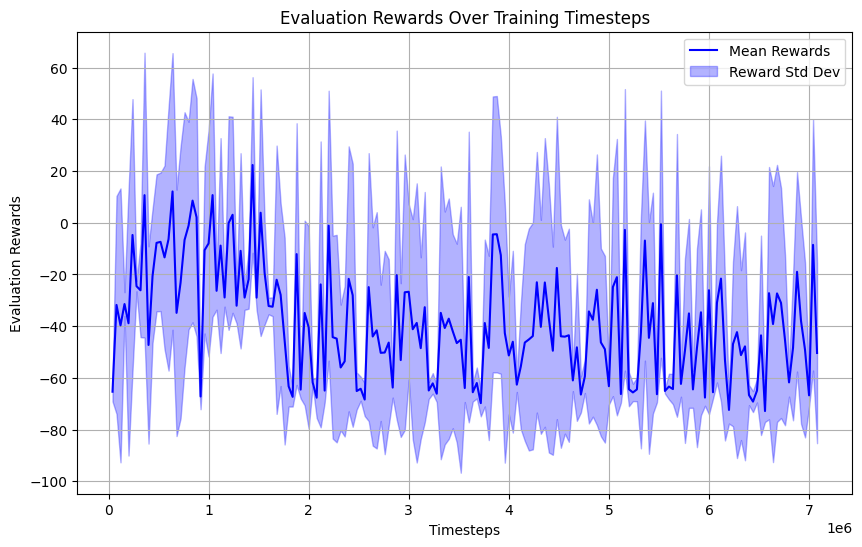

In [ ]:
plot_mean_rewards(timesteps_baseline_dqn, results_baseline_dqn)

 mean scaled between 22.5 and -72 with its variance going as far as 120, this is the only model that manages to have positive values

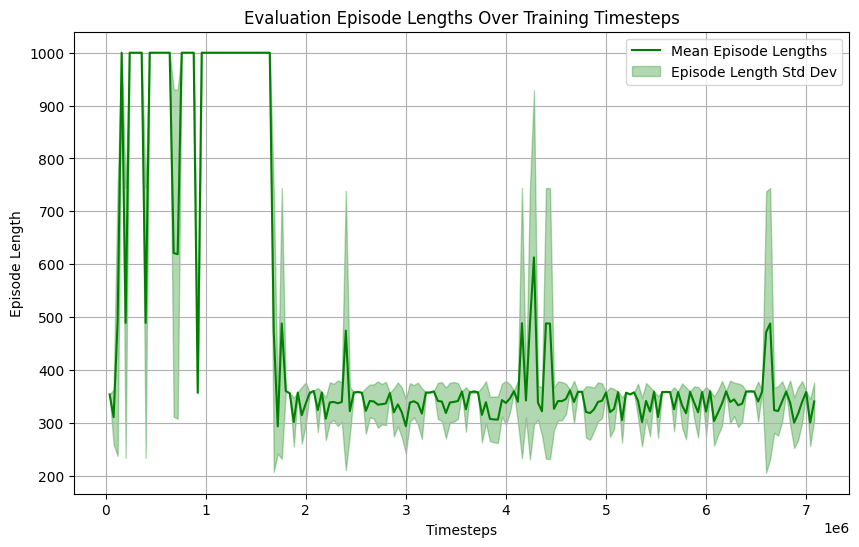

In [ ]:
plot_episode_lengths(timesteps_baseline_dqn, ep_lengths_baseline_dqn)

untill almost the first two timesteps the simulations tended to not reach the goal the simulations where ended due to reaching the episode lenght's limit (1000) alterwards, most of the timesteps lasted between 300 to 400 episodes

#### 2.1.2. PPO

Proximal Policy Optimization (PPO) is a reinforcement learning algorithm introduced by OpenAI. It improves policy learning by ensuring stable updates while keeping implementation simple. PPO uses a clipped objective function to limit large changes to the policy, balancing stability and efficiency.

Key properties:
- **On-policy**: Learns from the current policy's interactions.
- **Actor-Critic**: Combines a policy (actor) and a value function (critic).
- **Clipping Mechanism**: Constrains updates to avoid performance collapse.


In [2]:
env = gym.make("CarRacing-v3", continuous=False)
obs = env.reset()

In [ ]:
#create directories
logs_dir = 'PPO_baseline_logs'
logs_path = os.path.join(MODELS_DIR, logs_dir)
os.makedirs(logs_path, exist_ok=True)

video_dir = os.path.join(logs_path, "videos")
tensorboard_dir = os.path.join(logs_path, "tensorboard")
model_dir = os.path.join(logs_path, "models")
os.makedirs(video_dir, exist_ok=True)
os.makedirs(tensorboard_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Simple DQN architecture
policy_kwargs = dict(net_arch=[64, 64])  # Simpler architecture with 2 layers of 64 units

# Set up the model with simpler hyperparameters
model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs, 
            verbose=1, learning_rate=0.0005, batch_size=32)

# Setup evaluation and checkpoint callbacks
eval_callback = EvalCallback(env, best_model_save_path=model_dir,
                             log_path=model_dir, eval_freq=5000, n_eval_episodes=5,
                             deterministic=True, render=False)

checkpoint_callback = CheckpointCallback(save_freq=10000, save_path=model_dir,
                                         name_prefix='ppo_model_checkpoint')



# Start training the model with callbacks for evaluation and checkpoints
model.learn(total_timesteps=1_000_000, callback=[eval_callback, checkpoint_callback])

# Save the final model after training
model.save("ppo_env_model")
env.close()

In [ ]:
env.close()
del env
foo = gc.collect()

In [ ]:
# Load the evaluations.npz file
evaluations = np.load("models/baseline/PPO/evaluations.npz")

# List the available keys
print(f"Keys in evaluations.npz: {evaluations.files}")

# Extract relevant data
timesteps_baseline_ppo = evaluations['timesteps']  # Training steps
results_baseline_ppo = evaluations['results']  # Mean rewards (or similar metrics)
ep_lengths_baseline_ppo = evaluations['ep_lengths']  # Episode lengths


Keys in evaluations.npz: ['timesteps', 'results', 'ep_lengths']


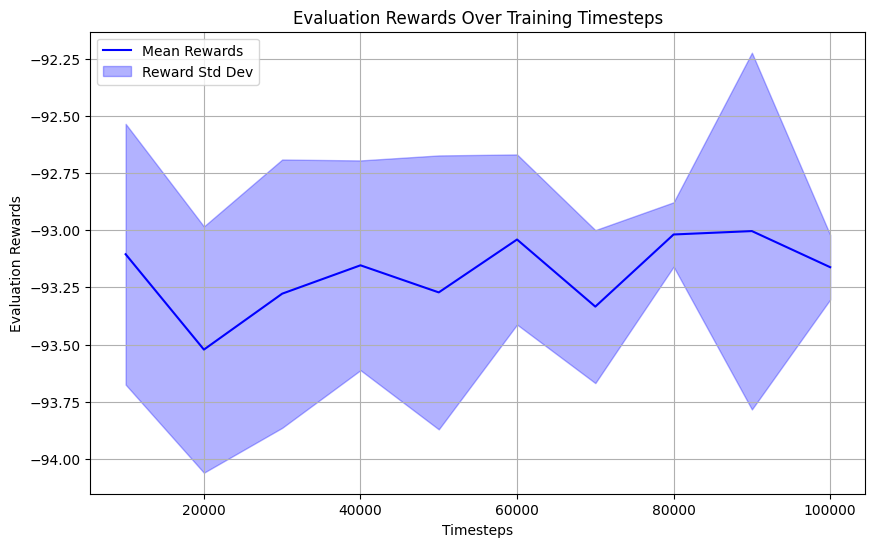

In [ ]:
plot_mean_rewards(timesteps_baseline_ppo, results_baseline_ppo)

an overall stable mean with little diviation, values ar all scaled between -91 and -95

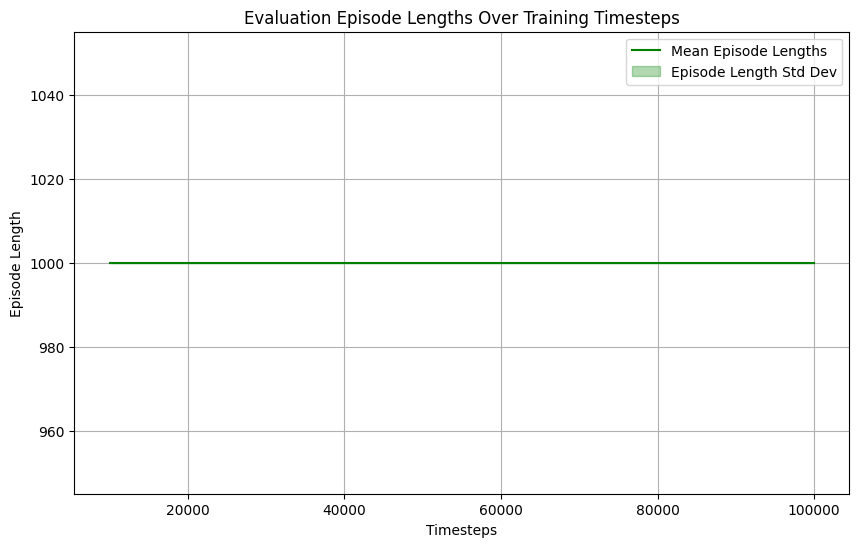

In [ ]:
plot_episode_lengths(timesteps_baseline_ppo, ep_lengths_baseline_ppo)

all timesteps reached the maximum ending the simulation

### 2.2. Environment and Reward Modifications

| **Modification**            | **Description**                                                                                      | **Effect**                                     |
|-----------------------------|------------------------------------------------------------------------------------------------------|-----------------------------------------------|
| **Obstacles**               | Randomly placed obstacles on the track.                                                             | Requires avoidance and navigation skills.     |
| **Track Width Variability** | Random track width adjustments between `[0.8, 1.2]`.                                                | Simulates narrow/wide tracks dynamically.     |
| **Weather Conditions**      | Introduces "rain" and "snow," which alter action effectiveness.                                     | Adds randomness and realism to driving.       |
| **Off-Track Penalty**       | Reward reduced by `-10` if the car leaves the track.                                                | Encourages the agent to stay on track.        |
| **Distance Reward**         | Positive reward based on the distance traveled per step.                                            | Incentivizes efficient driving.               |
| **Obstacle Proximity Penalty** | Penalty inversely proportional to the distance to nearby obstacles (`1 / (d + 1e-6)`).             | Encourages the car to avoid obstacles safely. |


In [3]:
custom_env = EnhancedCarRacing(render_mode="rgb_array")
obs, info = custom_env.reset()

print("Initial observation shape:", obs.shape)
print("Initial info:", info)

for i in range(10):
    action = custom_env.action_space.sample()  # Your agent would make a decision here
    observation, reward, terminated, truncated, info = custom_env.step(action)
    print(f"\nStep {i+1}:")
    print("Action taken:", action)
    print("Reward:", reward)
    print("Terminated:", terminated)
    print("Truncated:", truncated)
    print("Info:", info)

    if hasattr(custom_env, 'weather_condition'):
        print("Current weather:", custom_env.weather_condition)
    
    if terminated or truncated:
        print("Episode ended")
        break

custom_env.close()

Initial observation shape: (96, 96, 3)
Initial info: {}

Step 1:
Action taken: 2
Reward: 5.804336925215569
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 2:
Action taken: 3
Reward: -0.37469043040753186
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 3:
Action taken: 0
Reward: -0.4746904304075319
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 4:
Action taken: 0
Reward: -0.5746904304075319
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 5:
Action taken: 1
Reward: -0.6746904304075318
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 6:
Action taken: 3
Reward: -0.7746904304075318
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 7:
Action taken: 1
Reward: -0.8746904304075318
Terminated: False
Truncated: False
Info: {}
Current weather: rain

Step 8:
Action taken: 0
Reward: -0.9746904304075318
Terminated: False
Truncated: False
Info: {}
Current weather

#### 2.2.1 DQN

In [ ]:
custom_env = EnhancedCarRacing(render_mode="rgb_array")
obs, info = custom_env.reset()

In [4]:
custom_env = GrayscaleObservation(custom_env, keep_dim=True)
custom_env = TimeLimit(custom_env, max_episode_steps=1000)

In [5]:
print(custom_env)

<TimeLimit<GrayscaleObservation<EnhancedCarRacing instance>>>


In [6]:
print("Action space:", custom_env.action_space)

Action space: Discrete(5)


In [7]:
#create directories
logs_dir = 'DQN_env_mod_logs'
logs_path = os.path.join(MODELS_DIR, logs_dir)
os.makedirs(logs_path, exist_ok=True)

tensorboard_dir = os.path.join(logs_path, "tensorboard")
model_dir = os.path.join(logs_path, "models")
os.makedirs(tensorboard_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Simple DQN architecture
policy_kwargs = dict(net_arch=[64, 64])  # Simpler architecture with 2 layers of 64 units

# Set up the model with simpler hyperparameters
model = DQN('CnnPolicy', custom_env, policy_kwargs=policy_kwargs, 
            verbose=1, buffer_size=50000, learning_starts=1000, 
            learning_rate=0.0005, batch_size=32, exploration_fraction=0.1,
            exploration_final_eps=0.05)

# Setup evaluation and checkpoint callbacks
eval_callback = EvalCallback(custom_env, best_model_save_path=model_dir,
                             log_path=model_dir, eval_freq=5000, n_eval_episodes=5,
                             deterministic=True, render=False)

checkpoint_callback = CheckpointCallback(save_freq=10000, save_path=model_dir,
                                         name_prefix='dqn_model_checkpoint')



# Start training the model with callbacks for evaluation and checkpoints
model.learn(total_timesteps=1_000_000, callback=[eval_callback, checkpoint_callback])

# Save the final model after training
model.save("dqn_custom_env_model")
custom_env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[W1218 10:05:02.050906178 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.
/home/derpy/Documents/Fac/ano3/semestre1/ISIA/reinforcement-learning-with-gymnasium/.venv/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7eaf196b5eb0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7eaf159685c0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1e+03     |
|    ep_rew_mean      | -5.02e+04 |
|    exploration_rate | 0.962     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 28        |
|    time_elapsed     | 141       |
|    total_timesteps  | 4000      |
| train/              |           |
|    learning_rate    | 0.0005    |
|    loss             | 5.12      |
|    n_updates        | 749       |
-----------------------------------


/home/inesamorim46/3ano1sem/isia/reinforcement-learning-with-gymnasium/.venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-50215.65 +/- 9.31
Episode length: 1000.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 1e+03     |
|    mean_reward      | -5.02e+04 |
| rollout/            |           |
|    exploration_rate | 0.953     |
| time/               |           |
|    total_timesteps  | 5000      |
| train/              |           |
|    learning_rate    | 0.0005    |
|    loss             | 3.93      |
|    n_updates        | 999       |
-----------------------------------
New best mean reward!
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 1e+03     |
|    ep_rew_mean      | -5.02e+04 |
|    exploration_rate | 0.924     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 17        |
|    time_elapsed     | 463       |
|    total_timesteps  | 8000      |
| train/              |           |
|    learning_rate    

In [34]:
custom_env.close()
del custom_env
foo = gc.collect()

In [ ]:
# Load the evaluations.npz file
evaluations = np.load("models/custom/DQN/evaluations.npz")

# List the available keys
print(f"Keys in evaluations.npz: {evaluations.files}")

# Extract relevant data
timesteps_custom_dqn = evaluations['timesteps']  # Training steps
results_custom_dqn = evaluations['results']  # Mean rewards (or similar metrics)
ep_lengths_custom_dqn = evaluations['ep_lengths']  # Episode lengths


Keys in evaluations.npz: ['timesteps', 'results', 'ep_lengths']


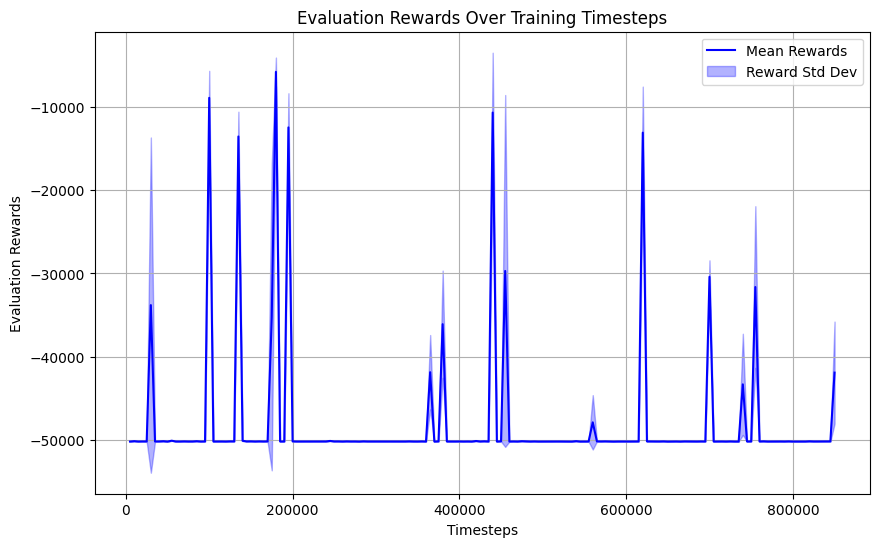

In [ ]:
plot_mean_rewards(timesteps_custom_dqn, results_custom_dqn)

all values are negative being the majoroty arrond -50000 with spontanuos spikes that can reach further than -10000

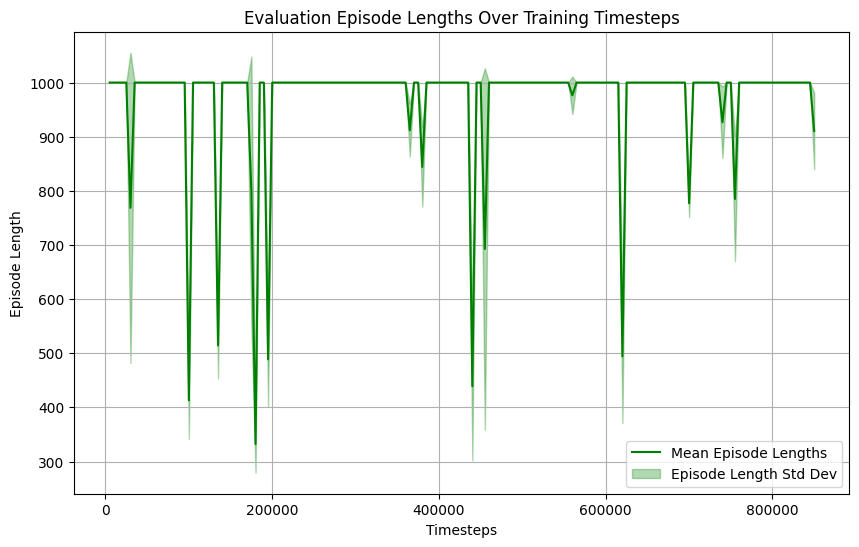

In [ ]:
plot_episode_lengths(timesteps_custom_dqn, ep_lengths_custom_dqn)

most of the values round 1000 episodes(failed to reach the goal) with some ocasional cases that are most likelly suecides from part of the car rather that reachig the goal

#### 2.2.2 PPO

In [11]:
custom_env = EnhancedCarRacing(render_mode="rgb_array")
obs, info = custom_env.reset()
custom_env = GrayscaleObservation(custom_env, keep_dim=True)
custom_env = TimeLimit(custom_env, max_episode_steps=1000)

In [12]:
#create directories
logs_dir = 'PPO_env_mod_logs'
logs_path = os.path.join(MODELS_DIR, logs_dir)
os.makedirs(logs_path, exist_ok=True)

tensorboard_dir = os.path.join(logs_path, "tensorboard")
model_dir = os.path.join(logs_path, "models")
os.makedirs(tensorboard_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [13]:
# Simple DQN architecture
policy_kwargs = dict(net_arch=[64, 64])  # Simpler architecture with 2 layers of 64 units

# Set up the model with simpler hyperparameters
model = PPO('CnnPolicy', custom_env, policy_kwargs=policy_kwargs, 
            verbose=1, learning_rate=0.0005, batch_size=32)

# Setup evaluation and checkpoint callbacks
eval_callback = EvalCallback(custom_env, best_model_save_path=model_dir,
                             log_path=model_dir, eval_freq=5000, n_eval_episodes=5,
                             deterministic=True, render=False)

checkpoint_callback = CheckpointCallback(save_freq=10000, save_path=model_dir,
                                         name_prefix='ppo_model_checkpoint')



# Start training the model with callbacks for evaluation and checkpoints
model.learn(total_timesteps=1_000_000, callback=[eval_callback, checkpoint_callback])

# Save the final model after training
model.save("ppo_custom_env_model")
custom_env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[W1217 21:07:15.281412367 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.
/home/derpy/Documents/Fac/ano3/semestre1/ISIA/reinforcement-learning-with-gymnasium/.venv/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x76bd92db0620> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x76bd92db1970>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -5.02e+04 |
| time/              |           |
|    fps             | 77        |
|    iterations      | 1         |
|    time_elapsed    | 26        |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -5.02e+04    |
| time/                   |              |
|    fps                  | 55           |
|    iterations           | 2            |
|    time_elapsed         | 73           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0035775134 |
|    clip_fraction        | 0.0174       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.22        |
|    explained_variance   | 4.82e-05     |
|    

/home/derpy/Documents/Fac/ano3/semestre1/ISIA/reinforcement-learning-with-gymnasium/.venv/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-50217.84 +/- 10.32
Episode length: 1000.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | -5.02e+04    |
| time/                   |              |
|    total_timesteps      | 5000         |
| train/                  |              |
|    approx_kl            | 0.0011489361 |
|    clip_fraction        | 0.0149       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.18        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0005       |
|    loss                 | 3.68e+05     |
|    n_updates            | 20           |
|    policy_gradient_loss | 0.000451     |
|    std                  | 0.975        |
|    value_loss           | 8.78e+05     |
------------------------------------------
New best mean reward!
----------------------------------
| rollout/           |           

In [ ]:
env.close()
del env
foo = gc.collect()

In [ ]:
#Load the evaluations.npz file
evaluations = np.load("models/baseline/PPO/evaluations.npz")

# List the available keys
print(f"Keys in evaluations.npz: {evaluations.files}")

# Extract relevant data
timesteps_custom_ppo = evaluations['timesteps']  # Training steps
results_custom_ppo = evaluations['results']  # Mean rewards (or similar metrics)
ep_lengths_custom_ppo = evaluations['ep_lengths']  # Episode lengths

In [ ]:
# Load the evaluations.npz file
evaluations = np.load("models/custom/PPO/evaluations.npz")

# List the available keys
print(f"Keys in evaluations.npz: {evaluations.files}")

# Extract relevant data
timesteps = evaluations['timesteps']  # Training steps
results = evaluations['results']  # Mean rewards (or similar metrics)
ep_lengths = evaluations['ep_lengths']  # Episode lengths


Keys in evaluations.npz: ['timesteps', 'results', 'ep_lengths']


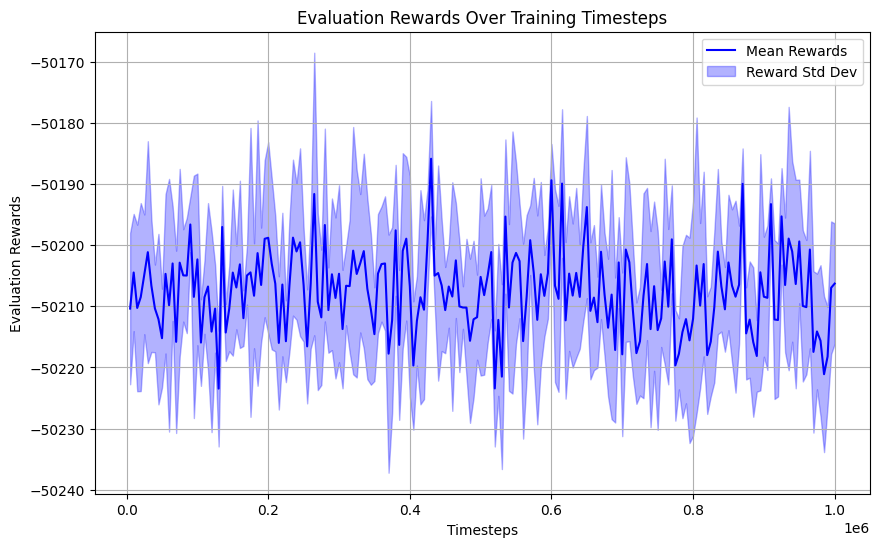

In [ ]:
plot_mean_rewards(timesteps, results)

the mean scales between -50185 and -50223 with its average around -50205, the variance is relatively low

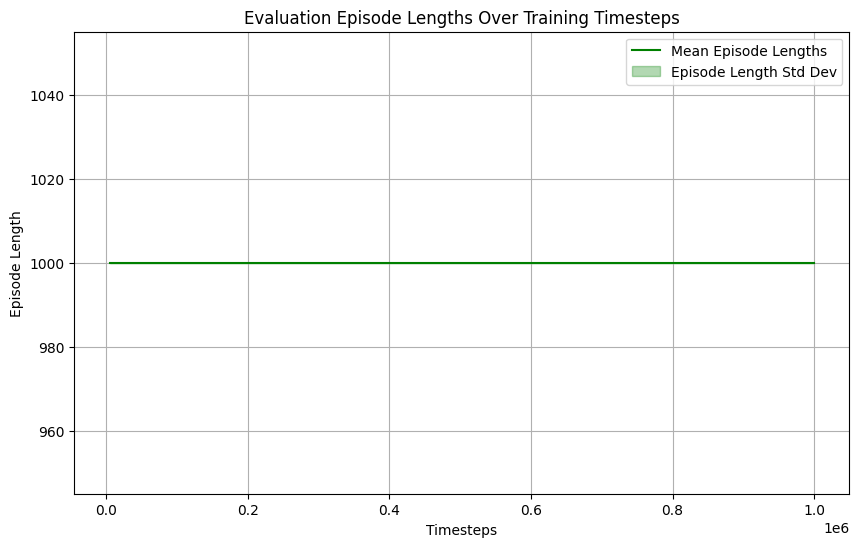

In [ ]:
plot_episode_lengths(timesteps, ep_lengths)

like the baseline, all timesteps have failed to reach the goal considering the previous model these results where to be expected

---

## 3. Evaluation

### 3.1. Baseline DQN vs Custom DQN

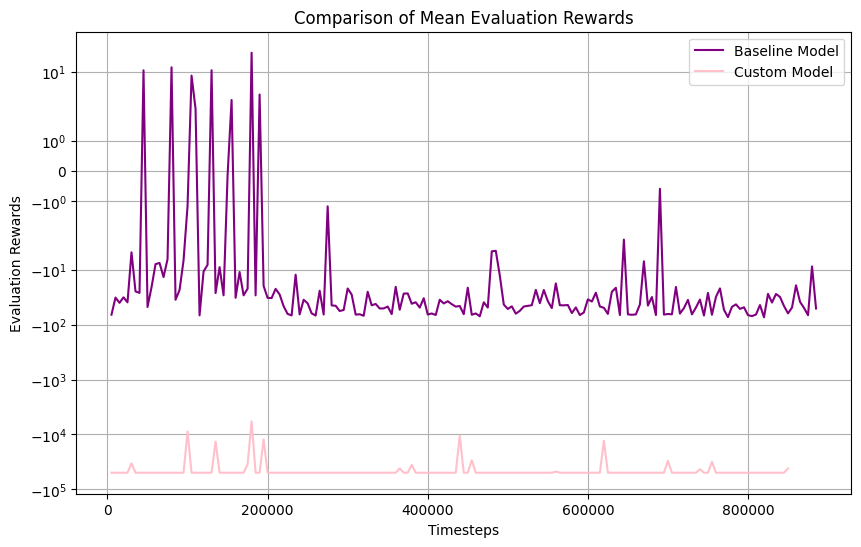

In [ ]:
compare_rewards(timesteps_baseline_dqn, timesteps_custom_dqn, results_baseline_dqn, results_custom_dqn)

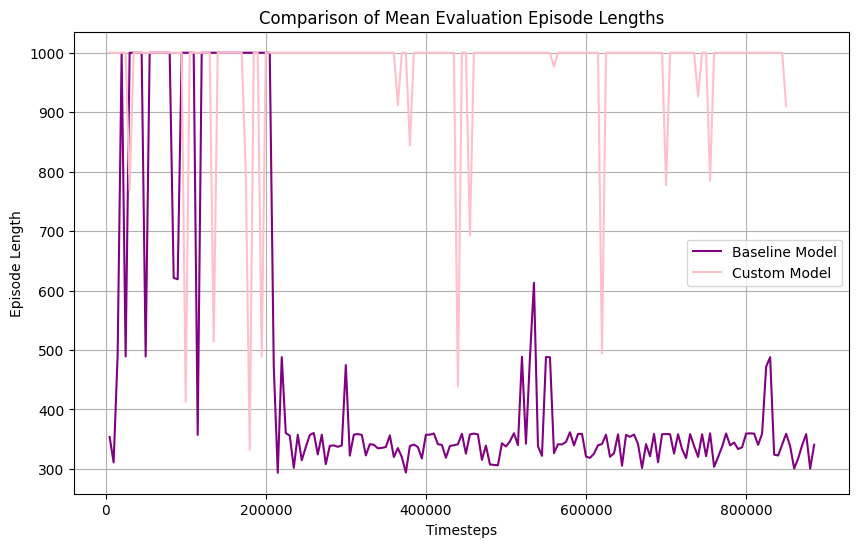

In [ ]:
compare_episode_lengths(timesteps_baseline_dqn, timesteps_custom_dqn, ep_lengths_baseline_dqn, ep_lengths_custom_dqn)

### 3.2 Baseline PPO vs Custom PPO

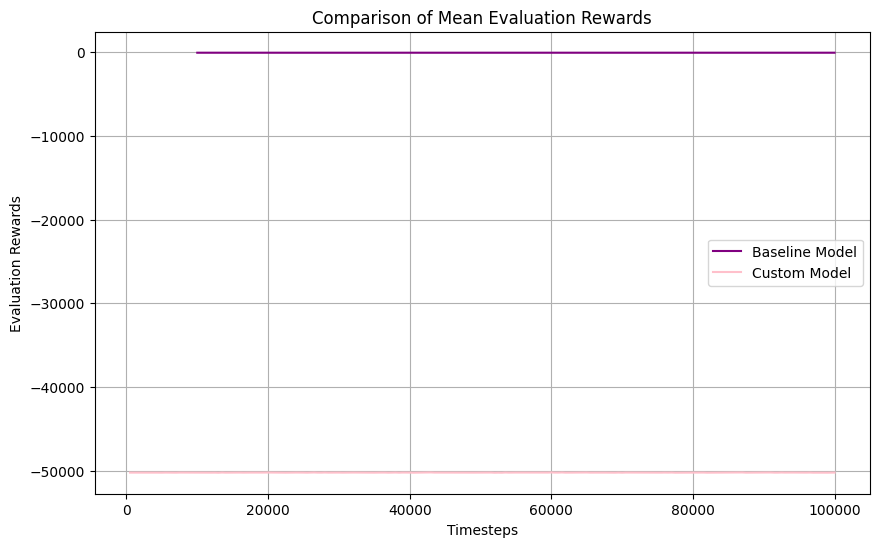

In [ ]:
compare_rewards(timesteps_baseline_ppo, timesteps_custom_ppo, results_baseline_ppo, results_custom_ppo)

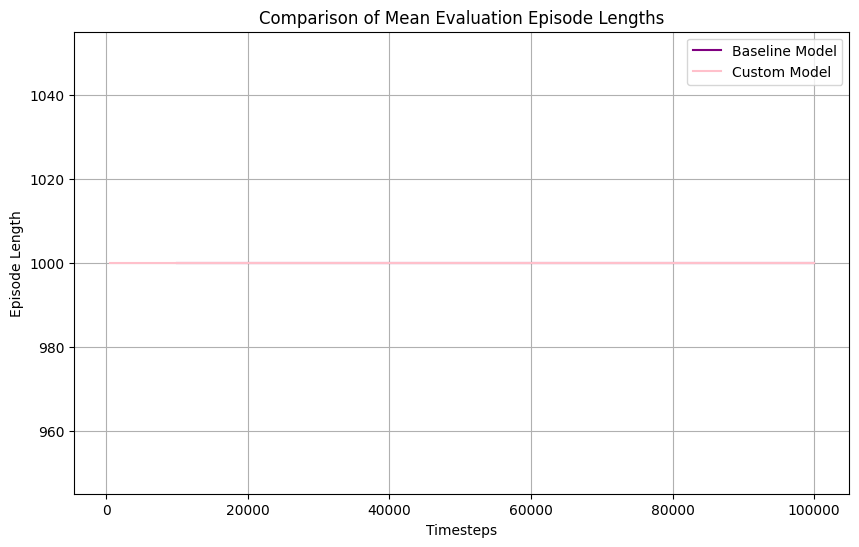

In [ ]:
compare_episode_lengths(timesteps_baseline_ppo, timesteps_custom_ppo, ep_lengths_baseline_ppo, ep_lengths_custom_ppo)

---

# Gravar os video

In [12]:
def record_video(env, model, save_path):
    # Video recorder wrapper
    trigger = lambda t: t == 0
    env = RecordVideo(
        env,
        video_folder=save_path,
        episode_trigger=trigger,
        video_length=0,
        disable_logger=True,
    )

    obs, info = env.reset()
    trunc, done = False, False
    i = 0
    while not trunc and not done:
        # pass observation to model to get predicted action
        action, _states = model.predict(obs, deterministic=True)

        # pass action to env and get info back
        obs, rewards, trunc, done, info = env.step(action)

        # show the environment on the screen
        env.render()
        print(i)
        i += 1

    # Close the Environment
    env.close()

In [ ]:
# DQN original

# Define a Environment
env = gym.make("CarRacing-v3", continuous=False, render_mode='rgb_array')

model = DQN.load(path="models/baseline/DQN/best_model.zip", env=env)

record_video(env, model, "./recordings/original/DQN")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/isia/trab2/Gym-RL-Project-ISIA/.venv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.77GB > 0.74GB
  warnings.warn(


Running episode 0


In [ ]:
# PPO original

# Define a Environment
env = gym.make("CarRacing-v3", continuous=False, render_mode='rgb_array')
env = GrayscaleObservation(env, keep_dim=True)
env = TimeLimit(env, max_episode_steps=1000)

model = PPO.load(path="models/custom/PPO/best_model.zip", env=env)

record_video(env, model, "./recordings/custom/PPO")

In [7]:
# DQN custom

# Define a Environment
env = EnhancedCarRacing(render_mode="rgb_array")
env = GrayscaleObservation(env, keep_dim=True)
# env = TimeLimit(env, max_episode_steps=1000)

model = DQN.load(path="models/custom/DQN/best_model.zip", env=env)

record_video(env, model, "./recordings/custom/DQN")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
# PPO custom

# Define a Environment
env = EnhancedCarRacing(render_mode="rgb_array")
env = GrayscaleObservation(env, keep_dim=True)
env = TimeLimit(env, max_episode_steps=500)

model = PPO.load(path="models/custom/PPO/best_model.zip", env=env)

record_video(env, model, "./recordings/custom/PPO")